# Used this notebook to play around with functions in test.py

In [3]:
import json
import os
import shutil
from datetime import datetime, timedelta

import numpy as np
from bson import json_util
from tqdm import tqdm
import lz4.frame as lz4

import helix as hx
from helix import units
import numpy as np
import strax as sx                    
import numba
import pandas as pd
import scipy as sp
import sys
import os
import shutil
from glob import glob
from matplotlib import pyplot as plt
run = 'run10' 
duration = 10  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run, 'events')

raw_data = events['channel_data']
raw_data.shape

Loading events: |                   | 0.00 % [00:00<?], #2 (0.02 s). 4715.0 MB/s


(18, 50, 33168)

In [4]:
def plot_psd(context, run):#KeyError: 'No plugin class registered that provides chunk_noise_psds'
    psds = context.get_array(run, 'chunk_noise_psds')
    for psd in psds:
        #plt.figure(figsize=(5, ))
        plt.loglog(psd['frequencies'], psd['psd'])
        plt.xlabel('Frequencies (Hz)')
        plt.ylabel('PSD (A$^2$/Hz)')
        plt.ylim(1e-6, 1e-2)
        plt.show()
        break


def plot_pulses(context, run):#KeyError: 'No plugin class registered that provides of_rqs'
    of_rqs = context.get_array(run, 'of_rqs')
    traces = context.get_array(run, 'traces')

    fig, ax = plt.subplots(6, 1, figsize=(5, 8), sharex=True)
    for i, rqs in enumerate(of_rqs):
        mask = (traces['channel'] == rqs['channel']) & (traces['block_id'] == rqs['block_id']) \
               & (traces['event_id'] == rqs['event_id'])
        assert mask.sum() == 1, 'there should be exactly one trace with these fields'
        t = traces[mask][0]

        template = np.load('plugins/event_rqs/default_templates.npy', allow_pickle=True)
        ax[i].plot(t['data'])
        ax[i].plot(np.roll(template, rqs['OF_time']) * rqs['OF_amplitude'])
        ax[i].set_ylim(-50, 550)
        if i == 5:
            break
    ax[-1].set_xlim(3000, 5500)
    ax[3].set_ylabel('Current (ADC units)')
    ax[-1].set_xlabel('Time (samples)')
    plt.show()


def check_traces_and_records(context, run):
    events = context.get_array(run, 'events')
    records = context.get_array(run, 'raw_records')
    uv_triggers = context.get_array(run, 'uv_triggers')
    qp_triggers = context.get_array(run, 'qp_triggers')
    noise_events = context.get_array(run, 'noise_events')

    channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

    for i in np.sort(np.unique(records['block_id'])):
        record_mask = records['block_id'] == i
        plt.figure(figsize=(16, 10))
        for ch in channels:
            mask = record_mask & (records['channel'] == ch)
            record = records['data'][mask][0]
            add_baseline = 300 * ch
            baseline = np.median(record) + add_baseline
            plt.plot(record + add_baseline, color='C0', lw=0.5)

            for triggers, color in zip([uv_triggers, qp_triggers], ['C1', 'C3']):
                mask = (triggers['channel'] == ch) & (triggers['block_id'] == i)
                # trigger_amplitudes = triggers[mask]['amplitude']
                y = np.ones_like(triggers[mask]['loc']) * baseline
                marker_size = 4
                plt.plot(triggers[mask]['loc'], y, '.', color=color, markersize=marker_size)
                plt.plot(triggers[mask]['start_loc'], y, '>', color=color, markersize=marker_size)
                plt.plot(triggers[mask]['start_loc'] + triggers[mask]['length'], y, '<', color=color,
                         markersize=marker_size)

        record_events = events[events['block_id'] == i]

        if len(record_events) == 0:
            plt.xlabel('Time (samples)')
            plt.ylabel('Current w/artificial baselines (ADC)')
            plt.show()
            continue

        for event_id in np.unique(record_events['event_id']):
            event = record_events[record_events['event_id'] == event_id]
            assert len(event) == 1, f'Expect 1 event, but found {len(event)}'

            t = event[0]
            plt.axvspan(t['start_loc'], t['start_loc'] + t['length'], alpha=0.2, color='C0')

            for i_ch, ch in enumerate(channels):
                t1 = t['start_loc']
                t2 = t['start_loc'] + t['length']
                record_ch_mask = record_mask & (records['channel'] == ch)
                record = records['data'][record_ch_mask][0]
                assert np.all(np.abs(t['channel_data'][i_ch] - record[t1:t2]) < 1e-6), \
                    'Trace data should be the same as the corresponding piece of record'

            for summed_channel_mask, trace in zip(t['summed_channel_masks'], t['data']):
                assert np.allclose(trace, t['channel_data'][summed_channel_mask].sum(axis=0))

        record_events = noise_events[noise_events['block_id'] == i]

        if len(record_events) == 0:
            plt.xlabel('Time (samples)')
            plt.ylabel('Current w/artificial baselines (ADC)')
            plt.show()
            continue

        for event_id in np.unique(record_events['event_id']):
            event = record_events[record_events['event_id'] == event_id]
            assert len(event) == 1, f'Expect 1 event, but found {len(event)}'

            t = event[0]
            plt.axvspan(t['start_loc'], t['start_loc'] + t['length'], alpha=0.2, color='C3')

        plt.xlabel('Time (samples)')
        plt.ylabel('Current w/artificial baselines (ADC)')
        plt.show()

        i += 1
        if i > 10:
            break


def view_raw_records(context, run):
    records = context.get_array(run, 'raw_records')

    channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

    for i in np.sort(np.unique(records['block_id'])):
        record_mask = records['block_id'] == i
        plt.figure(figsize=(12, 10))
        for ch in channels:
            mask = record_mask & (records['channel'] == ch)
            record = records['data'][mask][0]
            add_baseline = 300 * ch
            plt.plot(record + add_baseline, color='C0', lw=0.5)

        plt.xlabel('Time (samples)')
        plt.ylabel('Current w/artificial baselines (ADC)')
        plt.show()

        i += 1
        if i > 3:
            break


def check_uv_and_qp_triggers(context, run):
    records = context.get_array(run, 'raw_records')
    uv_triggers = context.get_array(run, 'uv_triggers')
    qp_triggers = context.get_array(run, 'qp_triggers')

    for i in range(2):
        for ch in [1, 40]:
            record = records[i]
            block_id = record['block_id']
            plt.plot(record['data'] - np.median(record['data']))

            for triggers, color in zip([uv_triggers, qp_triggers], ['C1', 'C3']):
                mask = (triggers['channel'] == ch) & (triggers['block_id'] == block_id)
                trigger_amplitudes = triggers[mask]['amplitude']
                plt.plot(triggers[mask]['loc'], trigger_amplitudes, '.', color=color)
                plt.plot(triggers[mask]['start_loc'], trigger_amplitudes, '>', color=color)
                plt.plot(triggers[mask]['start_loc'] + triggers[mask]['length'], trigger_amplitudes, '<', color=color)
            plt.show()


def show_noise_events(context, run):
    noise_events = context.get_array(run, 'noise_events')

    channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)
    vac_channels_indices = channels.indices_of_type(hx.ChannelType.VACUUM)

    plt.figure(figsize=(15, 10))
    for k, i_ch in enumerate(vac_channels_indices[[0, 5, 10]]):
        for i in range(2):# no idea what 2 here stand for 
            plt.plot(noise_events['channel_data'][i, i_ch], color=f'C{k}', alpha=0.3, lw=0.5)
        plt.plot(np.mean(noise_events['channel_data'][:, i_ch], axis=0), color=f'C{k}', lw=2)


    plt.show()


def check_psds(context, run):#ValueError: no field of name n_traces

    psds = context.get_array(run, 'noise_psds')[0]

    print(psds['time'] / units.s, psds['endtime'] / units.s, psds['n_traces'])

    # Vacuum channels
    channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)
    vac_channels_indices = channels.indices_of_type(hx.ChannelType.VACUUM)
    scd_indices = hx.get_csd_index(len(channels), hx.get_all_growing_pairs(vac_channels_indices))
    vac_channels_psd = np.sum(psds['psds'][vac_channels_indices], axis=0) + 2*np.sum(psds['csds'][scd_indices], axis=0)

    print(np.allclose(vac_channels_psd,
                      psds['summed_channel_psds'][psds['summed_channel_types'] == hx.ChannelType.VACUUM_SUMMED][0]))

    mpl.rcParams.update({'font.size': 12})
    plt.figure(figsize=(8, 6))
    for i in vac_channels_indices:
        plt.semilogx(psds['frequencies'], psds['psds'][i], color='gray', alpha=0.5, lw=0.5)
    for i in scd_indices:
        plt.semilogx(psds['frequencies'], psds['csds'][i], color='red', alpha=0.5, lw=0.5)
    plt.semilogx(psds['frequencies'],
               psds['summed_channel_psds'][psds['summed_channel_types'] == hx.ChannelType.VACUUM_SUMMED][0])
    plt.semilogx(psds['frequencies'], vac_channels_psd, label='PSD of the vacuum channels summed')
    symlob_threshold = 1e-4
    plt.yscale('symlog', linthresh=symlob_threshold)
    plt.axhline(symlob_threshold, color='lightgray', ls='--', lw=1, alpha=0.5)
    plt.axhline(-symlob_threshold, color='lightgray', ls='--', lw=1, alpha=0.5)

    plt.plot(0, 0, '-', color='gray', alpha=0.5, lw=0.5, label='Vacuum channels PSDs')
    plt.plot(0, 0, '-', color='red', alpha=0.5, lw=0.5, label='Vacuum channels CSDs (real parts)')
    plt.xlabel('Frequencies (Hz)')
    plt.ylabel('Spectral Densities (A$^2$/Hz)')
    plt.legend()
    plt.show()


def debug_psds_and_fits():
    run_id = 'run10'
    helix_data_dir = 'test_helix_data'  # to save the run metadata

    # duration = 10  # seconds
    # raw_data_dir = 'toy_data'  # to save the raw toy data
    # baseline_step = 100  # add a baseline equal to baseline_step*channel_index to each channel
    # hx.generate_toy_data(run_id, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True,
    #                      baseline_step=baseline_step)

    # creating context, registering storage and plugins
    context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                         register=[hx.MMCRecords,
                                   hx.QPTriggers, hx.UVTriggers,
                                   hx.Events, hx.NoiseEvents,
                                   hx.NoisePSDs, hx.FitResults])  # all the plugins required for getting fit_results

    # creating a dictionary of plugins' options that we want to modify.
    config = {'run_metadata_directory': helix_data_dir,  # for the hx.ToyDataRawRecords plugin
              'noise_events_random_seed': 1,
              'fit_summed_triggered_channels': True,
              }

    # passing the settings to the plugins. Strax finds which plugins take these options automatically
    context.set_config(config)

    # for path in glob(f'{helix_data_dir}/{run_id}-*'):
    #     if 'metadata' in path:
    #         continue
    #     if os.path.isdir(path):
    #         shutil.rmtree(path)
    #     else:
    #         os.remove(path)

    # running the processing (or retrieving the data, if it was processed earlier)
    # _ = context.get_array(run_id, 'qp_triggers')
    # _ = context.get_array(run_id, 'uv_triggers')
    # _ = context.get_array(run_id, 'events')
    # _ = context.get_array(run_id, 'noise_events')
    # _ = context.get_array(run_id, 'noise_psds')  # hx.FitResults plugin provides this data type

    fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type
    plt.hist(fit_results['vacuum_channel_fit_chi2'].flatten(), bins=np.linspace(0,2,41))
    plt.show()
    print(len(fit_results))




Loading events: |                   | 0.00 % [00:00<?], #2 (0.01 s). 4973.7 MB/s
Loading raw_records: |              | 0.00 % [00:00<?], #1 (0.05 s). 2637.3 MB/s
Loading uv_triggers: |                 | 0.00 % [00:00<?], #1 (0.00 s). 1.4 MB/s
Loading qp_triggers: |                 | 0.00 % [00:00<?], #1 (0.00 s). 0.0 kB/s
Loading noise_events: |             | 0.00 % [00:00<?], #1 (0.01 s). 4748.3 MB/s


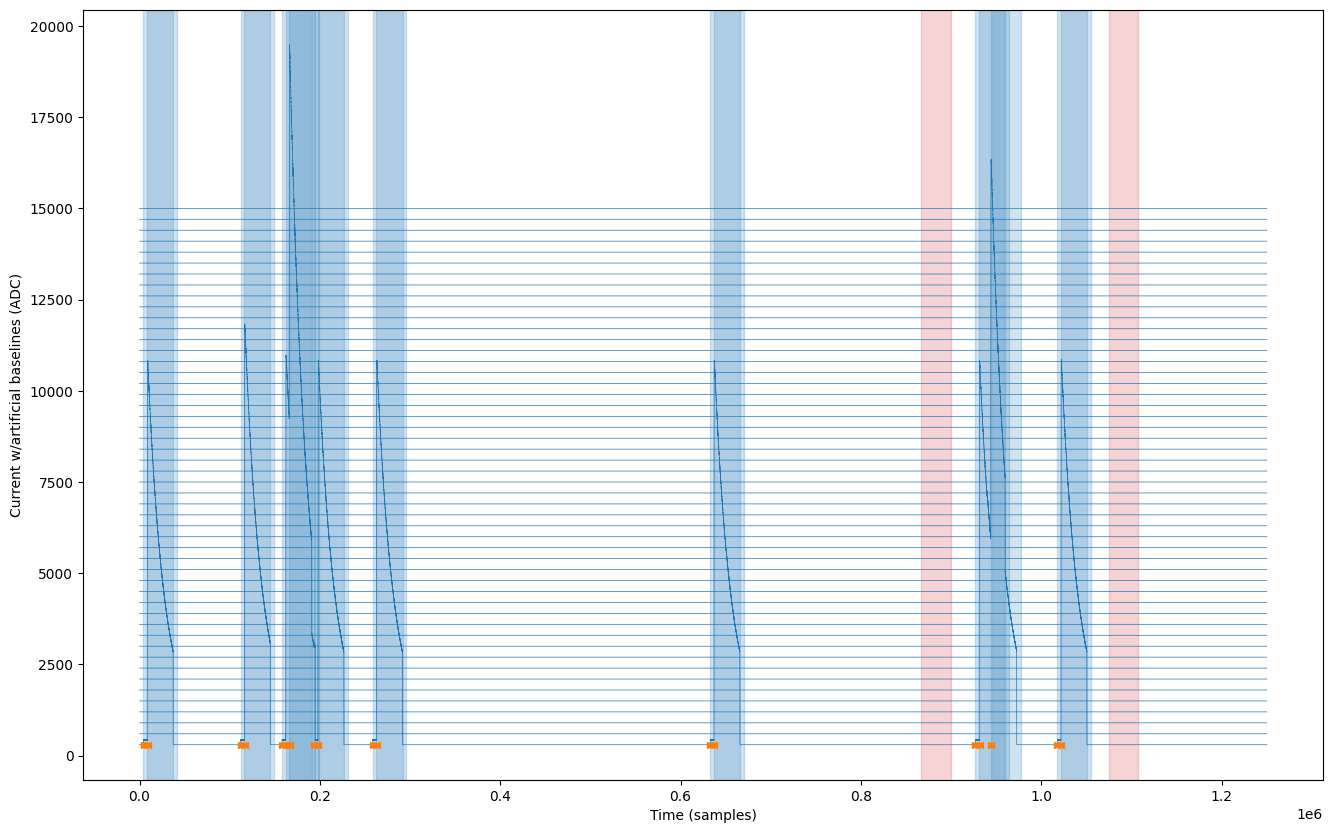

In [4]:
check_traces_and_records(context, run)

Loading raw_records: |              | 0.00 % [00:00<?], #1 (0.05 s). 2734.8 MB/s


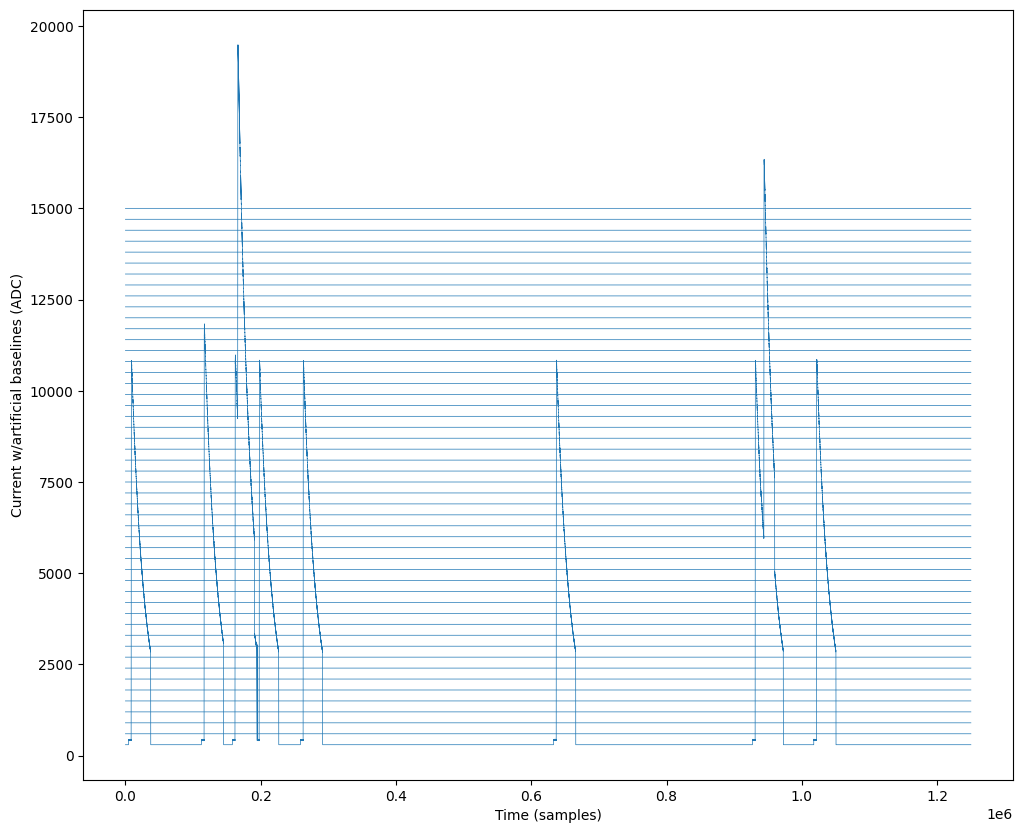

In [7]:
view_raw_records(context, run)

Loading raw_records: |              | 0.00 % [00:00<?], #1 (0.05 s). 2694.9 MB/s
Loading uv_triggers: |               | 0.00 % [00:00<?], #1 (0.00 s). 911.2 kB/s
Loading qp_triggers: |                 | 0.00 % [00:00<?], #1 (0.00 s). 0.0 kB/s


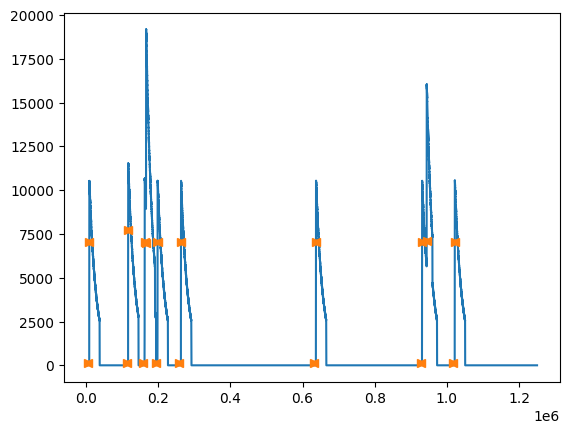

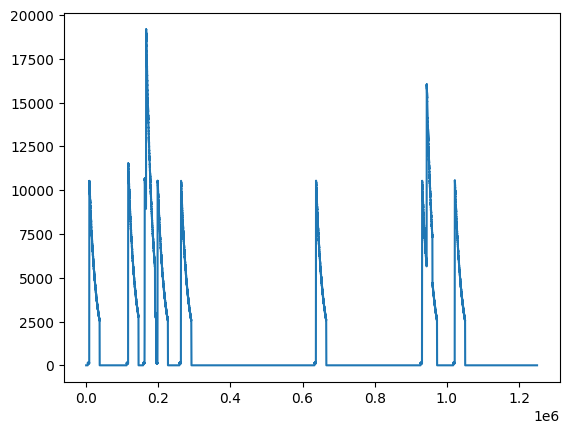

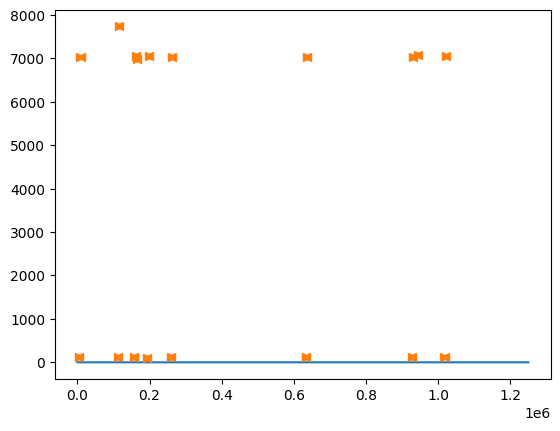

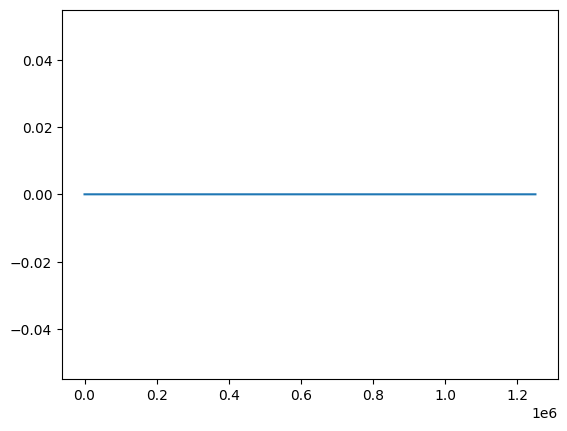

In [10]:
check_uv_and_qp_triggers(context, run)

Loading noise_events: |             | 0.00 % [00:00<?], #1 (0.00 s). 5926.5 MB/s


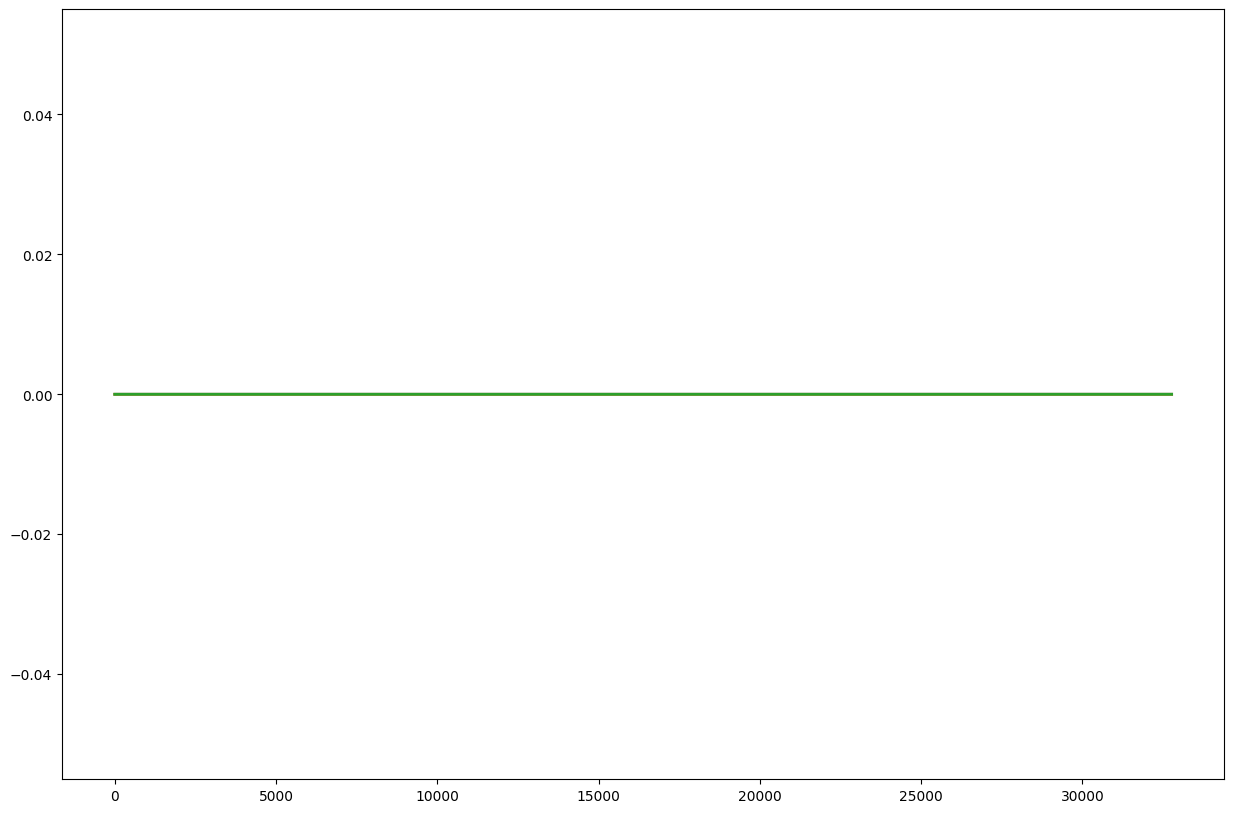

In [18]:
show_noise_events(context, run)

Loading fit_results: |                 | 0.00 % [00:04<?], #2 (1.18 s). 6.5 kB/s


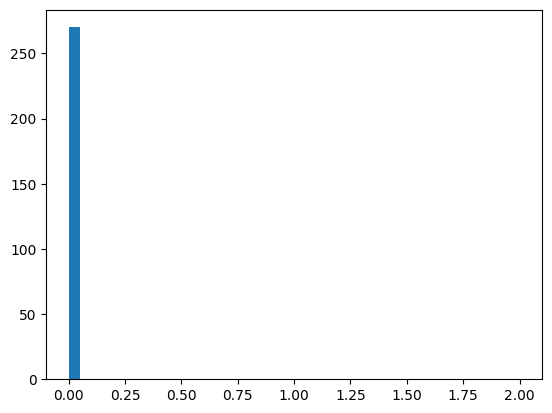

18


In [5]:
debug_psds_and_fits()